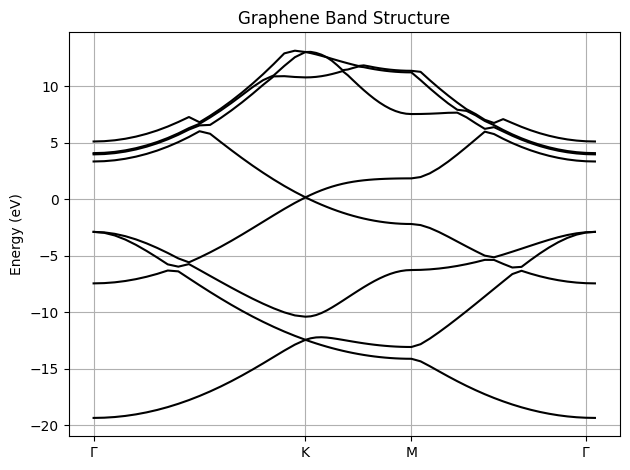

In [1]:
import matplotlib.pyplot as plt

# Read the bands.dat.gnu file
with open("graphene.bands.dat.gnu") as f:
    lines = f.readlines()

# Parse blocks separated by blank lines
bands = []
k = []
band = []
for line in lines:
    line = line.strip()
    if line == "":
        if band:
            bands.append(band)
            band = []
    else:
        parts = line.split()
        k.append(float(parts[0]))
        band.append(float(parts[1]))

# Catch final band
if band:
    bands.append(band)

# Deduplicate k-path
num_kpoints = len(bands[0])
# k_vals = k[:num_kpoints]

# Get unique k-point distances (x-axis values)
k_vals = []
with open("graphene.bands.dat.gnu") as f:
    for line in f:
        if line.strip() == "":
            break  # only read first band block
        k_vals.append(float(line.split()[0]))

# Get symmetry point positions
num_kpoints_per_segment = 20
xticks = [0, num_kpoints_per_segment, 2*num_kpoints_per_segment, 3*num_kpoints_per_segment - 1]
xtick_labels = ['Γ', 'K', 'M', 'Γ']
xtick_positions = [k_vals[i] for i in xticks]



fermi_energy = -2.5281  # from SCF
energies_shifted = [[e - fermi_energy for e in band] for band in bands]

# Plot
# for b in bands:
#     plt.plot(k_vals, b, color='black')

for b in energies_shifted:
    plt.plot(k_vals, b, color='black')


plt.xticks(xtick_positions, xtick_labels)
plt.ylabel("Energy (eV)")
plt.title("Graphene Band Structure")
plt.grid(True)
plt.tight_layout()
plt.show()


Shifted by Fermi energy such that E_f=0 right now.

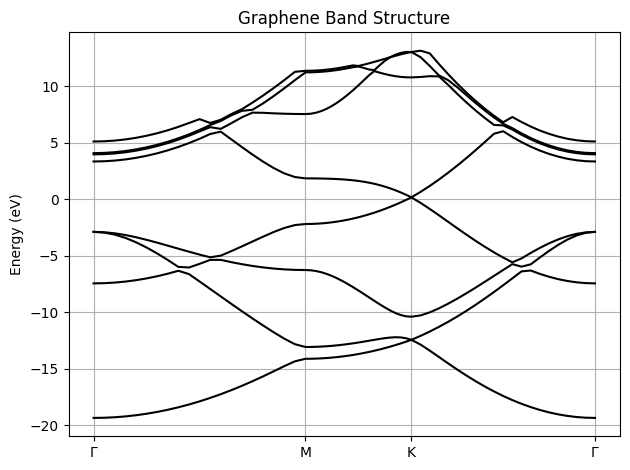

In [25]:
import matplotlib.pyplot as plt

# Read the bands.dat.gnu file
with open("graphene_2.dat.gnu") as f:
    lines = f.readlines()

# Parse blocks separated by blank lines
bands = []
k = []
band = []
for line in lines:
    line = line.strip()
    if line == "":
        if band:
            bands.append(band)
            band = []
    else:
        parts = line.split()
        k.append(float(parts[0]))
        band.append(float(parts[1]))

# Catch final band
if band:
    bands.append(band)

# Deduplicate k-path
num_kpoints = len(bands[0])
# k_vals = k[:num_kpoints]

# Get unique k-point distances (x-axis values)
k_vals = []
with open("graphene.bands.dat.gnu") as f:
    for line in f:
        if line.strip() == "":
            break  # only read first band block
        k_vals.append(float(line.split()[0]))

# Get symmetry point positions
num_kpoints_per_segment = 20
xticks = [0, num_kpoints_per_segment, 2*num_kpoints_per_segment, 3*num_kpoints_per_segment]
xtick_labels = ['Γ', 'M', 'K', 'Γ']
xtick_positions = [k_vals[i] for i in xticks]



fermi_energy = -2.5281  # from SCF
energies_shifted = [[e - fermi_energy for e in band] for band in bands]

# Plot
# for b in bands:
#     plt.plot(k_vals, b, color='black')

for b in energies_shifted:
    plt.plot(k_vals, b, color='black')


plt.xticks(xtick_positions, xtick_labels)
plt.ylabel("Energy (eV)")
plt.title("Graphene Band Structure")
plt.grid(True)
plt.tight_layout()
plt.show()


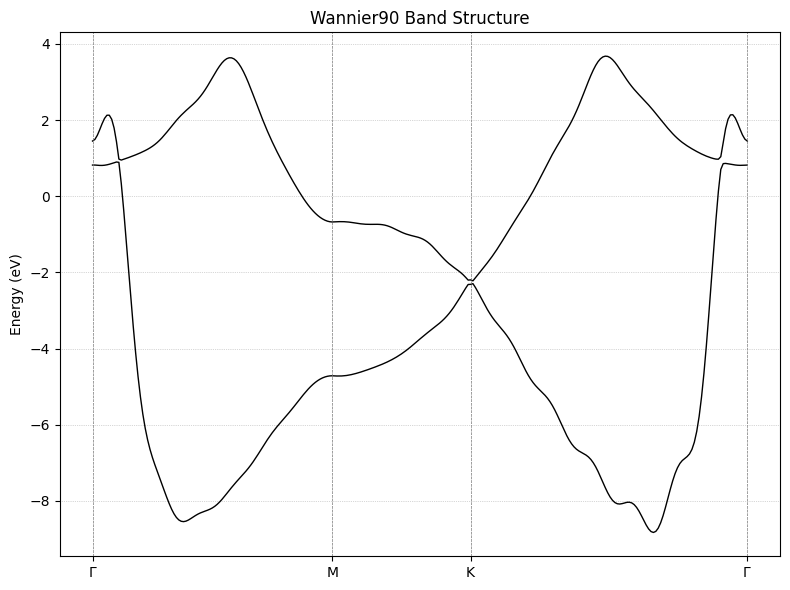

In [31]:
import numpy as np
# === Load band energies ===
bands = np.loadtxt("aiida_band.dat")
kpath_all = bands[:, 0]
energies_all = bands[:, 1]
# first column a k-point; second column are the band energies (in eV or Ry). Flattened, so one band then the other.
# Convert from Ry to eV if needed: 1 Ry = 13.6057 eV

# === Infer number of k-points and bands ===
nkpoints = max(np.loadtxt("aiida_band.labelinfo.dat", usecols=1, dtype=int))
npoints_total = len(kpath_all)
nbands = npoints_total // nkpoints

# Reshape arrays
kpath = kpath_all[:nkpoints]
energies = energies_all.reshape(nbands, nkpoints)

# === Load labels and x-ticks ===
labels = []
xticks = []
with open("aiida_band.labelinfo.dat") as f:
    for line in f:
        parts = line.strip().split()
        label = parts[0]
        index = int(parts[1])-1
        labels.append(r'$\Gamma$' if label in ('G', 'Γ') else label)
        xticks.append(index)

# === Plot ===
plt.figure(figsize=(8, 6))
for i in range(nbands):
    plt.plot(kpath, energies[i], color='black', linewidth=1)

for x in xticks:
    plt.axvline(x=kpath[x], color='gray', linewidth=0.5, linestyle='--')

plt.xticks([kpath[x] for x in xticks], labels)
plt.ylabel("Energy (eV)")
plt.title("Wannier90 Band Structure")
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


Note: Wannier does not use the same number of points per segment as QE does. We need to rescale each section of the path to ensure they match.

In [41]:
w_idx = []
with open("aiida_band.labelinfo.dat") as f:
    for line in f:
        w_idx.append(int(line.split()[1]) - 1)   # 0-based now
# w_idx = [Γ, M, K, Γ]  e.g. [0, 100, 158, 274]

# --- 2. indices (or just k-values) of the same points in the QE list ---
qe_idx = [0, 20, 40, 60]                # you already use these
qe_x   = np.array(k_vals)[qe_idx]       # physical x-positions in QE plot

# --- 3. build a piece-wise scaled x–axis for Wannier ---
kpath_scaled = np.empty_like(kpath)

for seg in range(3):                    # Γ→M, M→K, K→Γ
    i0, i1 = w_idx[seg], w_idx[seg+1]
    # scale factor for THIS segment only
    s = (qe_x[seg+1] - qe_x[seg]) / (kpath[i1] - kpath[i0])
    kpath_scaled[i0:i1+1] = qe_x[seg] + (kpath[i0:i1+1] - kpath[i0]) * s

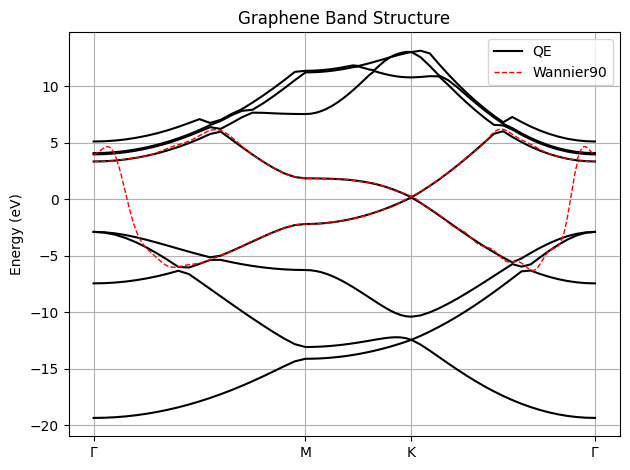

In [46]:
#Plot QE
for idx,b in enumerate(energies_shifted):
    if idx == 0:
        plt.plot(k_vals, b, color='black', label='QE')
    else:
        plt.plot(k_vals, b, color='black',)


#Plot Wannier
for i in range(nbands):
    if i ==0:
        plt.plot(kpath_scaled, energies[i]-fermi_energy,
             color='red', linestyle='--', linewidth=1, label='Wannier90')
    else:
        plt.plot(kpath_scaled, energies[i]-fermi_energy,
             color='red', linestyle='--', linewidth=1)

plt.xticks(xtick_positions, xtick_labels)
plt.ylabel("Energy (eV)")
plt.title("Graphene Band Structure")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()
